# Under-Representation Bias (w/ Synthetic Data)

This notebook recreates the finding that Equalized Odds constrained model can recover from under-representation bias.

### Setup

Please run the code block below to install the necessary packages (if needed).

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn.base import clone

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from collections import Counter

import fairlearn
from fairlearn.metrics import *
from fairlearn.reductions import *
import aif360

import copy, random

from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression

# Synthetic Dataset Generation

## Parameters (User Input)

In [2]:
'''

r is the proportion of training examples in the minority group, 

which means 1-r is proportion of examples in the majority group

eta is the probability of flipping the label

n is the number of training examples

beta is the probability of keeping a positively labeled example
from the minority class

NOTE: results can be replicated if and only if the following condition holds:

(1-r)(1-2*eta) + r((1-eta)*beta - eta) > 0

'''
def get_params(r = 1/3, eta = 1/4, n = 2000, beta = 0.5):
    return r, eta, n, beta

r, eta, n, beta = get_params(r = 1/3, eta = 0, n = 30000)

In [3]:
# check if above constraint holds
def check_constraints(r, eta, beta):
    first = (1-r)*(1-2*eta)
    second = r * ((1-eta)*beta - eta)
    res = first + second
    print("constraint: ", res)
    print("yes!", r, eta, beta) if res > 0 else print("no", r, eta, beta)
    
bias_amts = np.divide(list(range(10, -1, -1)),10)

for beta in bias_amts:
    check_constraints(r=0.2, eta=0.4, beta=beta)

constraint:  0.19999999999999996
yes! 0.2 0.4 1.0
constraint:  0.18799999999999997
yes! 0.2 0.4 0.9
constraint:  0.17599999999999996
yes! 0.2 0.4 0.8
constraint:  0.16399999999999998
yes! 0.2 0.4 0.7
constraint:  0.15199999999999997
yes! 0.2 0.4 0.6
constraint:  0.13999999999999996
yes! 0.2 0.4 0.5
constraint:  0.12799999999999997
yes! 0.2 0.4 0.4
constraint:  0.11599999999999996
yes! 0.2 0.4 0.3
constraint:  0.10399999999999997
yes! 0.2 0.4 0.2
constraint:  0.09199999999999997
yes! 0.2 0.4 0.1
constraint:  0.07999999999999996
yes! 0.2 0.4 0.0


## True Label Generation

In [4]:
# create minority and majority groups
def get_cat_features(n, r):
    num_minority = int(r * n)
    num_majority = n - num_minority
    
    minority = np.zeros((num_minority, 1))
    majority = np.ones((num_majority, 1))
    
    cat_features = np.vstack((minority, majority))
    #np.random.shuffle(cat_features) # this is what causes us to not recover coeffs
    
    return cat_features

In [5]:
# return labels from Bayes Optimal Classifier
def get_bayes_optimal_labels(features, effect_param, threshold = 0.5):
    outcome_continuous = 1/(1+np.exp(-np.matmul(features, effect_param)))
    #return outcome_continuous, np.random.binomial(1,outcome_continuous) # bernoulli to simulate LR's probabilistic nature
    return outcome_continuous, np.where(outcome_continuous < threshold, 0, 1)

# flip labels with probability eta
def flip_labels(df_synthetic, eta):
    labels = df_synthetic['outcome']
    #print('Before:', df_synthetic['outcome'].value_counts())
    num_flipped = 0
    for i in range(len(labels)):
        if random.uniform(0,1) <= eta:
            labels[i] = 1 if labels[i] == 0 else 0
            num_flipped += 1
    df_synthetic['outcome'] = labels
    #print('After:', df_synthetic['outcome'].value_counts())
    #print('Num Flipped: ', num_flipped, "\tRate: ", num_flipped / len(df_synthetic))
    return df_synthetic

def flip_labels2(df_majority, eta_maj, df_minority, eta_min):
    labels_maj = df_majority['outcome'].values
    labels_min = df_minority['outcome'].values
    
    num_flipped_maj = 0
    for i in range(len(labels_maj)):
        if random.uniform(0,1) <= eta_maj:
            labels_maj[i] = 1 if labels_maj[i] == 0 else 0
            num_flipped_maj += 1
    df_majority['outcome'] = labels_maj
    print('Num Flipped Maj: ', num_flipped_maj, "\tRate: ", num_flipped_maj / len(df_majority))
    
    num_flipped_min = 0
    for i in range(len(labels_min)):
        if random.uniform(0,1) <= eta_min:
            labels_min[i] = 1 if labels_min[i] == 0 else 0
            num_flipped_min += 1
    df_minority['outcome'] = labels_min
    print('Num Flipped Min: ', num_flipped_min, "\tRate: ", num_flipped_min / len(df_minority))
    
    df_concat = pd.concat([df_majority, df_minority])
    return df_concat.sample(frac=1, random_state = 42) # permute data

In [6]:
pd.options.mode.chained_assignment = None  # default='warn'
'''

create synthetic data with:
    3 numerical features (Gaussian), 1 categorical (sensitive attribute) 
    logistic outcome model s.t. outcome = Indicator[logit(effect_param*features) >= 0.5]
    
create minority/majority groups according to r param

simulate Bayes Optimal Classifiers for minority and majority

flip labels according to eta param

ensure equal base rates (proportion of positive examples) across both groups

'''

def true_label_generation(r, eta, n, maj_means = [0,0,0]):

    ''' 
    delete this variable to allow user to control percentage of positively labeled examples
    eg: let outcome_continuous >= 0.2 implies 80% positively labeled samples
    '''
    # causal effect params
    maj_params = [-0.7, 0.5, 1.5]
    effect_param_min = [0.5, -0.2, 0.1]
    #effect_param_maj = [i + np.random.uniform(low = -1, high = 1) for i in maj_params]
    effect_param_maj = maj_params
    
    num_min = int(n*r)
    num_maj = n - num_min

    # required: len(cat_probabilities) = n_cat_features
    n_cat_features = 2
    cat_probabilities = [0.5, 0.5] 

    # numerical feature params
    means = [0, 0, 0]
    cov_matrix = [[1, 0, 0], [0, 1, 0], [0, 0, 1]]

    # features
    cat_features = get_cat_features(r=r, n=n)
    
    num_features_min = np.random.multivariate_normal(means, cov_matrix, num_min)
    #num_features_min = np.random.normal(0, 1, num_min)
    num_features_maj = np.random.multivariate_normal(maj_means, cov_matrix, num_maj)
    # num_features_maj = np.array([i + np.random.uniform(low = -15, high = 10) for i in num_features_maj])
    #num_features_min = np.random.normal(0, 1, num_min)

    num_features = np.concatenate((num_features_min, num_features_maj))

    # outcomes
    outcome_continuous_min, outcome_binary_min = get_bayes_optimal_labels(features=num_features_min, effect_param=effect_param_min, threshold = 0.5)
    #outcome_binary_min = np.where(np.matmul(num_features_min, effect_param_min) > 0.5, 1, 0)
    outcome_continuous_maj, outcome_binary_maj = get_bayes_optimal_labels(features=num_features_maj, effect_param=effect_param_maj, threshold = 0.5)
    #outcome_binary_maj = np.where(np.matmul(num_features_maj, effect_param_maj) > 0.5, 1, 0)
    
    outcome = np.hstack((outcome_binary_min,outcome_binary_maj)).reshape(n,1)
    outcome_continuous = np.hstack((outcome_continuous_min,outcome_continuous_maj)).reshape(n,1)
    temp_data = np.hstack((num_features,cat_features, outcome, outcome_continuous))
    #print(outcome_continuous)
    #print(np.where(outcome_continuous < 0.5, 0, 1))
    np.random.shuffle(temp_data) # randomly shuffle the data
    
    df_synthetic = pd.DataFrame(temp_data)
    df_synthetic.columns = ['num1','num2','num3','cat','outcome','outcome_cont']
    
    outcome_continuous = df_synthetic.outcome_cont
    df_synthetic = df_synthetic[['num1','num2','num3','cat','outcome']]
    
    df_majority = df_synthetic[df_synthetic['cat'] == 1]
    df_minority = df_synthetic[df_synthetic['cat'] == 0]
    
    #print('% Positive Majority: ', df_majority['outcome'].value_counts()[1] / len(df_majority))
    #print('\n% Positive Minority: ', df_minority['outcome'].value_counts()[1] / len(df_minority))
    print('Diff: ', df_majority['outcome'].value_counts()[1] / len(df_majority)- df_minority['outcome'].value_counts()[1] / len(df_minority))
    #print('\nTotal: ', df_majority['outcome'].value_counts())
    
    df_synthetic = flip_labels(df_synthetic, eta)
    
    # uncomment below to add diff eta for majority/minority
    #df_synthetic = flip_labels2(df_majority, 0.2, df_minority, eta) # group dependent label noise
    
    return outcome_continuous, df_synthetic 

outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n, maj_means = [0,0,0])
#xx = np.where(outcome_continuous < 0.5, 0, 1)
#print(eta)
#print(accuracy_score(xx,df_synthetic.outcome.values))

Diff:  -0.011249999999999982


# Preparation

### Data Preprocessing

In [7]:
# split into train and test
df_train = df_synthetic.loc[range(0,int(n/2)), :]
# if original dataset has odd number of samples, remove 1 sample to be even
if (n % 2 == 1):
    df_test = df_synthetic.loc[range(int(n/2)+1, n), :]
else:
    df_test = df_synthetic.loc[range(int(n/2), n), :]

df_fidel = df_synthetic.loc[range(n, len(df_synthetic)),:]
outcome_cts = outcome_continuous[n:len(df_synthetic)]
    
df_test_maj = df_test[df_test['cat'] == 1]
df_test_min = df_test[df_test['cat'] == 0]

# format data
X_true = df_test.iloc[:, :-1].values
y_true = df_test.iloc[:, -1].values

X_true_maj = df_test_maj.iloc[:, :-1].values
y_true_maj = df_test_maj.iloc[:, -1].values
X_true_min = df_test_min.iloc[:, :-1].values
y_true_min = df_test_min.iloc[:, -1].values

sens_attrs_true = [df_test['cat']]

# Bias Injection

In [8]:
# measurement bias
def inject_noise_num(df, feature, eps = 1):
    for i in range(len(df[feature])):
        df[feature].iloc[i] += np.random.normal(0, 1) * eps # standard normal

    return df

In [9]:
from numpy import percentile
def under_sample(df_minority_positive, beta):
    X_min = df_minority_positive.iloc[:, :].values
    
    # keep each example with probability beta
    num_dropped = 0
    for i in range(len(X_min)):
        if random.uniform(0,1) > beta:
            X_min = np.delete(X_min, 0, axis=0)
            num_dropped += 1
    #print("Total Deleted: ", num_dropped, "\t % Deleted: ", num_dropped / len(df_minority_positive))
    df_minority_positive = pd.DataFrame(pd.DataFrame(X_min))
    df_minority_positive.columns = ['num1','num2','num3','cat','outcome']
    return df_minority_positive


def get_biased_data(df_train, beta):
    df_majority = df_train[df_train['cat'] == 1]
    df_minority = df_train[df_train['cat'] == 0]
    
    # unfavored group with negative label
    df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

    # unfavored group with positive label (preferred)
    df_minority_positive = df_minority[df_minority['outcome'] == 1.0]
    
    # data frame without positively labeled examples from minority class
    df_total = pd.concat([df_majority, df_minority_negative])
    
    # under-sampling process
    df_undersampled = under_sample(df_minority_positive, beta)

    # combine undersampled and original favored class to create dataset
    df_concat = pd.concat([df_total,df_undersampled])
    
    return df_concat.sample(frac=1) # permute data


'''

# representation bias, under-sampling entire minority
def get_biased_data(df_train, beta):
    df_majority = df_train[df_train['cat'] == 1]
    df_minority = df_train[df_train['cat'] == 0]
    
    # under-sampling process
    df_undersampled = under_sample(df_minority, beta)

    # combine undersampled and original favored class to create dataset
    df_concat = pd.concat([df_majority,df_undersampled])
    
    return df_concat.sample(frac=1) # permute data
'''

def get_summary_num(df, feature):
    res = dict()
    res['attribute'] = feature

    data_min, data_max = df[feature].min(), df[feature].max()
    res['min'] = data_min
    res['max'] = data_max

    quartiles = percentile(df[feature], [25,50,75])
    res['1st Quartile'] = quartiles[0]
    res['2nd Quartile'] = quartiles[1]
    res['3rd Quartile'] = quartiles[2]

    return res

#print(len(df_train[(df_train['cat'] == 0) & (df_train['outcome'] == 1)]))
print(get_summary_num(df_train, 'num1'))
df_concat = get_biased_data(df_train, 0.5)
print(get_summary_num(df_concat, 'num1'))
#print(len(df_concat[(df_concat['cat'] == 0) & (df_concat['outcome'] == 1)]))

# for fairness measures later
df_sens = df_concat['cat']

# format data
X_bias = df_concat.iloc[:, :-1].values
y_bias = df_concat.iloc[:, -1].values

{'attribute': 'num1', 'min': -3.9023730955538047, 'max': 3.7270053786364468, '1st Quartile': -0.6564270310551581, '2nd Quartile': 0.02017650338075394, '3rd Quartile': 0.6794745916924324}
{'attribute': 'num1', 'min': -3.9023730955538047, 'max': 3.5699318980530386, '1st Quartile': -0.7281827087283339, '2nd Quartile': -0.06936610584840669, '3rd Quartile': 0.6091026897302785}


In [10]:
''' Nil-Jana's Suggestions '''

def transform(df, is_test = False, is_train = False):

    sens_feat = df.iloc[:, -2].values
    outcome = df.iloc[:, -1].values
    num_feats = df.iloc[:, :-2].values

    trans_feats = [] # x1a - x3a
    other_feats = [] # x1(1-a) - x3(1-a)
    # -2 for sensitive feature and label
    for i in range(len(df.columns) - 2):
        num_feat = df.iloc[:, i].values
        num_feat_transf = np.multiply(num_feat, sens_feat)
        trans_feats += [num_feat_transf.reshape((len(df),))]
        
        num_feat_other = df.iloc[:, i].values
        num_feat_other_transf = np.multiply(num_feat, (1-sens_feat))
        other_feats += [num_feat_other_transf.reshape((len(df),))]


    temp_data = np.hstack((other_feats[0].reshape((len(df),1)), other_feats[1].reshape((len(df),1)), other_feats[2].reshape((len(df),1)),
                           trans_feats[0].reshape((len(df),1)), trans_feats[1].reshape((len(df),1)), trans_feats[2].reshape((len(df),1)),
                           outcome.reshape((len(df),1))))

    df_transf = pd.DataFrame(temp_data)
    df_transf.columns = ['num1*(1-a)','num2*(1-a)','num3*(1-a)', 'num1*a','num2*a','num3*a','outcome']

    # for fairness measures later
    df_sens = df['cat']
    maj_list = list(df[df['cat'] == 1].index)
    min_list = list(df[df['cat'] == 0].index)
    
    for i in range(len(maj_list)):
        if is_train: maj_list[i] = maj_list[i]
        else: maj_list[i] = maj_list[i] - len(df)
        
    for i in range(len(min_list)):
        if is_train:
            min_list[i] = min_list[i]
        else: min_list[i] = min_list[i] - len(df)

    # format data
    X_bias = df_transf.iloc[:, :-1].values
    y_bias = df_transf.iloc[:, -1].values
    
    if not is_test:
        return X_bias, y_bias, df_sens
    else:
        return df_transf, maj_list, min_list

df_transf, _, _ = transform(df_test, True)

# Evaluation

In [11]:
def under(df, beta):
    X_min = df.iloc[:, :].values
    
    # keep each example with probability beta
    num_dropped = 0
    for i in range(len(X_min)):
        if random.uniform(0,1) > beta:
            X_min = np.delete(X_min, 0, axis=0)
            num_dropped += 1
    print("Total Deleted: ", num_dropped, "\t % Deleted: ", num_dropped / len(df))
    df = pd.DataFrame(pd.DataFrame(X_min))
    df.columns = ['num1','num2','num3','cat','outcome']
    return df

In [12]:
def tradeoff_visualization_error(classifier, r, n, apply_fairness = True, verbose = False, num_iters = 10):
    
    total_fidel_maj = []
    total_fidel_min = []
    total_fidel = []
    
    total_disp_bias_train = []
    total_disp_bo_train = []
    total_disp_mitigated_train = []
    
    total_disp_bias_test = []
    total_disp_bo_test = []
    total_disp_mitigated_test = []
    
    for i in range(num_iters):
    
        # 1 to 0 in increments of 0.1
        bias_amts = np.divide(list(range(10,-1,-1)),10)

        test_maj = []
        test_min = []
        total = []
        
        disp_bias_train = []
        disp_bo_train = []
        disp_mitigated_train = []
        
        disp_bias_test = []
        disp_bo_test = []
        disp_mitigated_test = []
        
        count = 0
        outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n)
        
        threshold = 0.5
        exact_bo_labels = np.where(outcome_continuous < threshold, 0, 1)
        exact_bo_labels_train = np.array(exact_bo_labels[range(0,n)])
        exact_bo_labels_test = np.array(exact_bo_labels[range(n,len(df_synthetic))])
        
        # split into train and test
        df_train = df_synthetic.loc[range(0,n), :]
        
        df_train_transf, maj_list, min_list = transform(df_train, True, True)
        
        df_test = df_synthetic.loc[range(n, len(df_synthetic)),:]
        df_test_transf, maj_list, min_list = transform(df_test, True, False)
        
        df_test_maj = df_test_transf.loc[maj_list]
        df_test_min = df_test_transf.loc[min_list]

        # format training data
        X_true = df_train_transf.iloc[:, :-1].values
        y_true = df_train_transf.iloc[:, -1].values
        
        # format test data
        X_test = df_test_transf.iloc[:, :-1].values
        X_test_maj = df_test_maj.iloc[:, :-1].values
        X_test_min = df_test_min.iloc[:, :-1].values
        y_test = df_test_transf.iloc[:, -1].values
        y_test_maj = df_test_maj.iloc[:, -1].values
        y_test_min = df_test_min.iloc[:, -1].values
        
        sens_attr_test = df_test['cat']
        
        for beta in bias_amts:
            
            if i == 0: print("Beta: ", beta, '\n')

            df_train_copy = df_train.copy()

            df_majority = df_train_copy[df_train_copy['cat'] == 1]
            df_minority = df_train_copy[df_train_copy['cat'] == 0]

            # unfavored group with negative label
            df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

            # unfavored group with positive label (preferred)
            df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

            # data frame without positively labeled examples from minority class
            df_total = pd.concat([df_majority, df_minority_negative])

            # under-sampling process
            df_undersampled = under(df_minority_positive, beta)

            # combine undersampled and original favored class to create dataset
            df_concat = pd.concat([df_total,df_undersampled]).sample(frac=1, random_state = 42)

            # format data
            X_bias_true, y_bias_true, df_sens = transform(df_concat)
            
            # model trained on biased data
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_bias = classifier.fit(X_bias_true, y_bias_true)
            
            acc = accuracy_score(y_test,classifier_bias.predict(X_test))
            #print(f'Biased classifier:')
            #print(f'     Test accuracy = {acc}')
            
            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bias_train += [disparity.gamma(classify).max()]

            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bias_test += [disparity.gamma(classify).max()]
            
            # Learned bayes optimal classifier
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_b = classifier.fit(X_true, y_true)                
            #classifier_b = clone(classifier).fit(X_true, y_true)
            acc = accuracy_score(y_test,classifier_b.predict(X_test))
            #print(f'Learned BO classifier:')
            #print(f'     Test accuracy = {acc}')
            
            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bo_train += [disparity.gamma(classify).max()]

            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bo_test += [disparity.gamma(classify).max()]
            
            
            # Exact BO optimal classifier
            #print(f'Exact BO classifier:')
            acc = accuracy_score(y_test,exact_bo_labels_test)
            #print(f'     Test accuracy = {acc}')
            acc = accuracy_score(y_true,exact_bo_labels_train)
            #print(f'     Train accuracy = {acc}')

            if apply_fairness:
                constraint = EqualizedOdds()
                classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none', fit_intercept = False, max_iter = 200)   

                classifier_mitigated_bias = GridSearch(estimator=classifier,
                                                       constraints=constraint,
                                                       selection_rule='tradeoff_optimization',
                                                       constraint_weight=0.5,
                                                       grid_size=10,
                                                       grid_limit=2.0,
                                                       grid_offset=None,
                                                       grid=None,
                                                       sample_weight_name='sample_weight')
                                                       
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
                
                acc = accuracy_score(y_test,classifier_mitigated_bias.predict(X_test))
                #print(f'Mitigated bias classifier:')
                #print(f'     Test accuracy = {acc}')
                
                m = classifier_mitigated_bias
                def classify(X): return m.predict(X)
                error = ErrorRate()
                error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                disparity = EqualizedOdds()
                disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                #print(f'     Train error = {error.gamma(classify)[0]}')
                #print(f'     Train disparity = {disparity.gamma(classify).max()}')
                disp_mitigated_train += [disparity.gamma(classify).max()]
                
                m = classifier_mitigated_bias
                def classify(X): return m.predict(X)
                error = ErrorRate()
                error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                disparity = EqualizedOdds()
                disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                #print(f'     Test error = {error.gamma(classify)[0]}')
                #print(f'     Test disparity = {disparity.gamma(classify).max()}')
                disp_mitigated_test += [disparity.gamma(classify).max()]
                
                # Alternative fidelity of intervention model to no intervention model
                alt_fid_train = accuracy_score(classifier_mitigated_bias.predict(X_bias_true),classifier_bias.predict(X_bias_true))
                alt_fid_test = accuracy_score(classifier_mitigated_bias.predict(X_test),classifier_bias.predict(X_test))
                #print(f'Alternative fidelity of intervention model to no intervention model: train = {alt_fid_train}, test = {alt_fid_test}')
                

            else:
                classifier_mitigated_bias = clone(classifier_bias)
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true)
                
                disp_mitigated_train += [0]
                disp_mitigated_test += [0]
                
                # NOTE: disparities are the same as for classifier_bias

                
            # Fidelity in this step
            fid = accuracy_score(classifier_mitigated_bias.predict(X_test),classifier_b.predict(X_test))
            #print(f'Test set fidelity of learned BO classifier and mitigated_bias_classifier: {fid}')
            fid = accuracy_score(classifier_mitigated_bias.predict(X_test),exact_bo_labels_test)
            #print(f'Test set fidelity of exact BO classifier and mitigated biased classifier: {fid}')
            fid = accuracy_score(classifier_bias.predict(X_test),classifier_b.predict(X_test))
            #print(f'Test set fidelity of learned BO classifier and biased classifier: {fid}')
            
            # fidelity check
            test_maj += [accuracy_score(classifier_mitigated_bias.predict(X_test_maj), classifier_b.predict(X_test_maj))]
            test_min += [accuracy_score(classifier_mitigated_bias.predict(X_test_min), classifier_b.predict(X_test_min))]
            total += [accuracy_score(classifier_mitigated_bias.predict(X_test), classifier_b.predict(X_test))]
                
            if verbose:
                print("Finished Iteration: ", count)
                count +=1
        
        #print(f'Fidelity test maj: {test_maj}')
        #print(f'Fidelity test min: {test_maj}')
        
        total_fidel_maj.append(test_maj)
        total_fidel_min.append(test_min)
        total_fidel.append(total)
        
        total_disp_bias_train.append(disp_bias_train)
        total_disp_bo_train.append(disp_bo_train)
        total_disp_mitigated_train.append(disp_mitigated_train)

        total_disp_bias_test.append(disp_bias_test)
        total_disp_bo_test.append(disp_bo_test)
        total_disp_mitigated_test.append(disp_mitigated_test)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)
    
    mean_fidel_maj = np.mean(total_fidel_maj, axis = 0)
    mean_fidel_min = np.mean(total_fidel_min, axis = 0)
    mean_fidel = np.mean(total_fidel, axis = 0)
    
    mean_disp_bias_train = np.mean(total_disp_bias_train, axis = 0)
    mean_disp_bo_train = np.mean(total_disp_bo_train, axis = 0)
    mean_disp_mitigated_train = np.mean(total_disp_mitigated_train, axis = 0)
    
    mean_disp_bias_test = np.mean(total_disp_bias_test, axis = 0)
    mean_disp_bo_test = np.mean(total_disp_bo_test, axis = 0)
    mean_disp_mitigated_test = np.mean(total_disp_mitigated_test, axis = 0)
    
    y_err_fidel_maj = np.std(total_fidel_maj, axis = 0)
    y_err_fidel_min = np.std(total_fidel_min, axis = 0)
    y_err_fidel = np.std(total_fidel, axis = 0)
    
    df = pd.DataFrame({"Biased Train" : mean_disp_bias_train,
                       "BO Train" : mean_disp_bo_train,
                       "Mitigated Train" : mean_disp_mitigated_train,
                       "Biased Test" : mean_disp_bias_test,
                       "BO Test" : mean_disp_bo_test,
                       "Mitigated Test" : mean_disp_mitigated_test})
   
    return bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df

### Section 4

In [ ]:
#Run experiments for section 4 and save data
import warnings
import time
warnings.simplefilter(action='ignore', category=FutureWarning)

for n in [300,3000,30000]:

    random.seed(42)
    np.random.seed(42)

    eta = 0.4
    r = 0.2
    num_iters = 50
    
    print(f'n={n}')
    
    print(f'Run simulation with intervention...')
    start_time = time.time()
    apply_fairness = True
    bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df = \
    tradeoff_visualization_error(r=r, n=n, apply_fairness=apply_fairness,verbose=False, num_iters=num_iters)
    df_res = pd.DataFrame(np.array([bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel]).T, columns=['bias_amts', 'mean_fidel_maj', 'mean_fidel_min', 'mean_fidel', 'y_err_fidel_maj', 'y_err_fidel_min', 'y_err_fidel'])
    df.to_csv(f'disp_with_intervention_numiters{num_iters}_n{n}_eta{eta}_fairness{apply_fairness}.csv', index = True)
    df_res.to_csv(f'fid_with_intervention_numiters{num_iters}_n{n}_eta{eta}_fairness{apply_fairness}.csv', index = True)
    print(f'Took {(time.time() - start_time)/60} minutes.')
    
    print(f'Run simulation without intervention...')
    start_time = time.time()
    apply_fairness = False
    bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df = \
    tradeoff_visualization_error(r = r, n = n, apply_fairness=apply_fairness,verbose=False, num_iters=num_iters)
    df_res = pd.DataFrame(np.array([bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel]).T, columns=['bias_amts', 'mean_fidel_maj', 'mean_fidel_min', 'mean_fidel', 'y_err_fidel_maj', 'y_err_fidel_min', 'y_err_fidel'])
    df.to_csv(f'disp_with_intervention_numiters{num_iters}_n{n}_eta{eta}_fairness{apply_fairness}.csv', index = True)
    df_res.to_csv(f'fid_with_intervention_numiters{num_iters}_n{n}_eta{eta}_fairness{apply_fairness}.csv', index = True)
    print(f'Took {(time.time() - start_time)/60} minutes.')

In [ ]:
#Make plots for section 4

for n in [300,3000,30000]:

    eta = 0.4
    num_iters = 50

    df_fair = pd.read_csv(f'fid_with_intervention_numiters{num_iters}_n{n}_eta{eta}_fairnessTrue.csv')
    df_bias = pd.read_csv(f'fid_with_intervention_numiters{num_iters}_n{n}_eta{eta}_fairnessFalse.csv')

    a = 0.5
    fig, ax = plt.subplots(figsize=(5,5))
    markers, caps, bars = ax.errorbar(1-df_fair.bias_amts, df_fair.mean_fidel_maj, yerr = df_fair.y_err_fidel_maj, 
                                      label = 'With intervention majority group', color = "orange",
                                      capsize=4, capthick=2)
    [bar.set_alpha(a) for bar in bars]
    [cap.set_alpha(a) for cap in caps]
    markers, caps, bars = ax.errorbar(1-df_fair.bias_amts, df_fair.mean_fidel_min, yerr = df_fair.y_err_fidel_min, 
                                      label = 'With intervention minority group', color = "orange",
                                      capsize=4, capthick=2, linestyle='--')
    [bar.set_linestyle('--') for bar in bars]
    [bar.set_alpha(a) for bar in bars]
    [cap.set_alpha(a) for cap in caps]
    markers, caps, bars = ax.errorbar(1-df_bias.bias_amts, df_bias.mean_fidel_maj, yerr = df_bias.y_err_fidel_maj, 
                                      label = 'Without intervention majority group', color = "blue",
                                      capsize=4, capthick=2)
    [bar.set_alpha(a) for bar in bars]
    [cap.set_alpha(a) for cap in caps]
    markers, caps, bars = ax.errorbar(1-df_bias.bias_amts, df_bias.mean_fidel_min, yerr = df_bias.y_err_fidel_min, 
                                      label = 'Without intervention minority group', color = "blue",
                                      capsize=4, capthick=2, linestyle='--')
    [bar.set_linestyle('--') for bar in bars]
    [bar.set_alpha(a) for bar in bars]
    [cap.set_alpha(a) for cap in caps]
    
    #plt.errorbar(df_fair.bias_amts, df_fair.mean_fidel_maj, yerr = df_fair.y_err_fidel_maj, label = 'With intervention majority group', color = "orange")
    #plt.errorbar(df_fair.bias_amts, df_fair.mean_fidel_min, yerr = df_fair.y_err_fidel_min, label = 'With intervention minority group', color = "orange", linestyle = '--')
    #plt.errorbar(df_bias.bias_amts, df_bias.mean_fidel_maj, yerr = df_bias.y_err_fidel_maj, label = 'Without intervention majority group', color = "blue")
    #plt.errorbar(df_bias.bias_amts, df_bias.mean_fidel_min, yerr = df_bias.y_err_fidel_min, label = 'Without intervention minority group', color = "blue", linestyle = '--')
    #plt.errorbar(bias_amts, mean_fidel, yerr = y_err_fidel, label = 'Total Fidelity', color = "blue")
    
    plt.xlabel(r"Amount of injected underrep. bias $1-\beta$")
    plt.ylabel(f"Fidelity with n={n}")
    #plt.xlim(1.05, -0.05)
    plt.ylim(0.35, 1.05)
    if n == 30000:
        plt.legend()
    plt.savefig(f'section4_n{n}.jpg',dpi=300)
    plt.show()

In [ ]:
for n in [300,3000,30000]:

    eta = 0.4
    num_iters = 50

    df_fair = pd.read_csv(f'fid_with_intervention_numiters{num_iters}_n{n}_eta{eta}_fairnessTrue.csv')
    df_bias = pd.read_csv(f'fid_with_intervention_numiters{num_iters}_n{n}_eta{eta}_fairnessFalse.csv')
    
    print(f'\nn={n}')
    print(f'Overall fid = {df_fair.mean_fidel.describe()}')
    print(f'Min fid = {df_fair.mean_fidel_min.describe()}')

In [197]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

random.seed(42)
np.random.seed(42)

eta = 0.2
n = 30000
r = 0.2
num_iters = 10

bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df = \
tradeoff_visualization_error(classifier,r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters)

df.to_csv(f'with_intervention_numiters{num_iters}_n{n}_eta{eta}.csv', index = True)

Diff:  0.008458333333333345
Beta:  1.0 

Total Deleted:  0 	 % Deleted:  0.0
Finished Iteration:  0
Beta:  0.9 

Total Deleted:  296 	 % Deleted:  0.10088616223585549
Finished Iteration:  1
Beta:  0.8 

Total Deleted:  576 	 % Deleted:  0.19631901840490798
Finished Iteration:  2
Beta:  0.7 

Total Deleted:  878 	 % Deleted:  0.2992501704158146
Finished Iteration:  3
Beta:  0.6 

Total Deleted:  1187 	 % Deleted:  0.4045671438309475
Finished Iteration:  4
Beta:  0.5 

Total Deleted:  1481 	 % Deleted:  0.5047716428084527
Finished Iteration:  5
Beta:  0.4 

Total Deleted:  1786 	 % Deleted:  0.6087252897068848
Finished Iteration:  6
Beta:  0.3 

Total Deleted:  2118 	 % Deleted:  0.721881390593047
Finished Iteration:  7
Beta:  0.2 

Total Deleted:  2338 	 % Deleted:  0.7968643490115883
Finished Iteration:  8
Beta:  0.1 

Total Deleted:  2634 	 % Deleted:  0.8977505112474438
Finished Iteration:  9
Beta:  0.0 

Total Deleted:  2934 	 % Deleted:  1.0
Finished Iteration:  10
Finished Total I

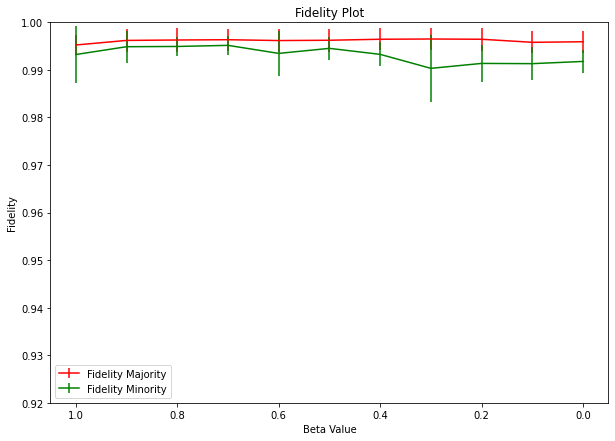

In [198]:
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, mean_fidel_maj, yerr = y_err_fidel_maj, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, mean_fidel_min, yerr = y_err_fidel_min, label = 'Fidelity Minority', color = "green")
#plt.errorbar(bias_amts, mean_fidel, yerr = y_err_fidel, label = 'Total Fidelity', color = "blue")
plt.xlabel("Beta Value")
plt.ylabel("Fidelity")
plt.xlim(1.05, -0.05)
plt.ylim(0.92, 1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig(f'with_intervention_numiters{num_iters}_n{n}_eta{eta}.jpg')
plt.show()

In [130]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

random.seed(42)
np.random.seed(42)

eta = 0.4
n = 30000
r = 0.2
num_iters = 10

bias_amts, mean_fidel_maj2, mean_fidel_min2, mean_fidel2, y_err_fidel_maj2, y_err_fidel_min2, y_err_fidel2, df = \
tradeoff_visualization_error(classifier,r = r, n = n, apply_fairness=False,verbose=True, num_iters=num_iters)

df.to_csv(f'without_intervention_numiters{num_iters}_n{n}_eta{eta}.csv', index = True)

Diff:  0.008458333333333345
Beta:  1.0 

Total Deleted:  0 	 % Deleted:  0.0
Finished Iteration:  0
Beta:  0.9 

Total Deleted:  298 	 % Deleted:  0.10215975317106617
Finished Iteration:  1
Beta:  0.8 

Total Deleted:  574 	 % Deleted:  0.19677751114158382
Finished Iteration:  2
Beta:  0.7 

Total Deleted:  875 	 % Deleted:  0.2999657182036339
Finished Iteration:  3
Beta:  0.6 

Total Deleted:  1180 	 % Deleted:  0.4045251971203291
Finished Iteration:  4
Beta:  0.5 

Total Deleted:  1481 	 % Deleted:  0.5077134041823792
Finished Iteration:  5
Beta:  0.4 

Total Deleted:  1766 	 % Deleted:  0.6054165238258484
Finished Iteration:  6
Beta:  0.3 

Total Deleted:  2107 	 % Deleted:  0.7223174494343504
Finished Iteration:  7
Beta:  0.2 

Total Deleted:  2329 	 % Deleted:  0.798423037367158
Finished Iteration:  8
Beta:  0.1 

Total Deleted:  2625 	 % Deleted:  0.8998971546109016
Finished Iteration:  9
Beta:  0.0 

Total Deleted:  2917 	 % Deleted:  1.0
Finished Iteration:  10
Finished Total I

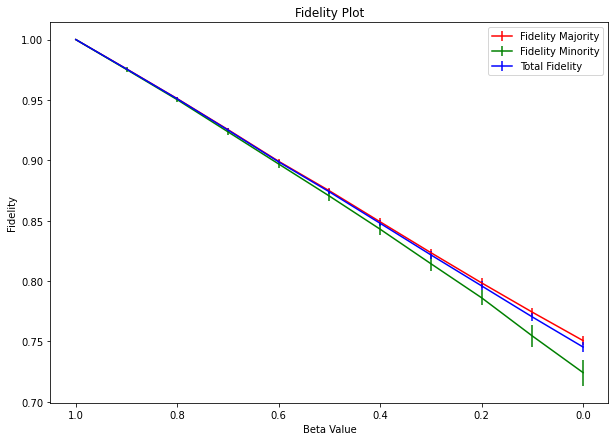

In [199]:
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, mean_fidel_maj2, yerr = y_err_fidel_maj2, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, mean_fidel_min2, yerr = y_err_fidel_min2, label = 'Fidelity Minority', color = "green")
plt.errorbar(bias_amts, mean_fidel2, yerr = y_err_fidel2, label = 'Total Fidelity', color = "blue")
plt.xlabel("Beta Value")
plt.ylabel("Fidelity")
plt.xlim(1.05, -0.05)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig(f'without_intervention_numiters{num_iters}_n{n}_eta{eta}.jpg')
plt.show()

In [132]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

random.seed(42)
np.random.seed(42)

eta = 0.4
n = 100000
r = 0.2
num_iters = 10

bias_amts, mean_fidel_maj2, mean_fidel_min2, mean_fidel2, y_err_fidel_maj2, y_err_fidel_min2, y_err_fidel2, df = \
tradeoff_visualization_error(classifier,r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters)

df.to_csv(f'with_intervention_numiters{num_iters}_n{n}_eta{eta}.csv', index = True)

Diff:  -0.002874999999999961
Beta:  1.0 

Total Deleted:  0 	 % Deleted:  0.0
Finished Iteration:  0
Beta:  0.9 

Total Deleted:  941 	 % Deleted:  0.09471565173628586
Finished Iteration:  1
Beta:  0.8 

Total Deleted:  1993 	 % Deleted:  0.20060392551585304
Finished Iteration:  2
Beta:  0.7 

Total Deleted:  2985 	 % Deleted:  0.3004529441368898
Finished Iteration:  3
Beta:  0.6 

Total Deleted:  4000 	 % Deleted:  0.40261701056869653
Finished Iteration:  4
Beta:  0.5 

Total Deleted:  4985 	 % Deleted:  0.501761449421238
Finished Iteration:  5
Beta:  0.4 

Total Deleted:  6046 	 % Deleted:  0.6085556114745848
Finished Iteration:  6
Beta:  0.3 

Total Deleted:  6978 	 % Deleted:  0.7023653749370911
Finished Iteration:  7
Beta:  0.2 

Total Deleted:  7926 	 % Deleted:  0.7977856064418721
Finished Iteration:  8
Beta:  0.1 

Total Deleted:  8950 	 % Deleted:  0.9008555611474585
Finished Iteration:  9
Beta:  0.0 

Total Deleted:  9935 	 % Deleted:  1.0
Finished Iteration:  10
Finished Tot

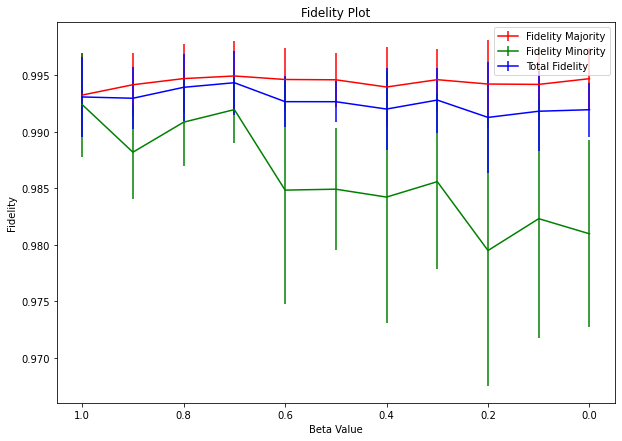

In [133]:
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, mean_fidel_maj2, yerr = y_err_fidel_maj2, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, mean_fidel_min2, yerr = y_err_fidel_min2, label = 'Fidelity Minority', color = "green")
plt.errorbar(bias_amts, mean_fidel2, yerr = y_err_fidel2, label = 'Total Fidelity', color = "blue")
plt.xlabel("Beta Value")
plt.ylabel("Fidelity")
plt.xlim(1.05, -0.05)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig(f'with_intervention_numiters{num_iters}_n{n}_eta{eta}.jpg')
plt.show()

In [134]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

random.seed(42)
np.random.seed(42)

eta = 0.4
n = 100000
r = 0.2
num_iters = 10

bias_amts, mean_fidel_maj2, mean_fidel_min2, mean_fidel2, y_err_fidel_maj2, y_err_fidel_min2, y_err_fidel2, df = \
tradeoff_visualization_error(classifier,r = r, n = n, apply_fairness=False,verbose=True, num_iters=num_iters)

df.to_csv(f'with_intervention_numiters{num_iters}_n{n}_eta{eta}.csv', index = True)

Diff:  -0.002874999999999961
Beta:  1.0 

Total Deleted:  0 	 % Deleted:  0.0
Finished Iteration:  0
Beta:  0.9 

Total Deleted:  941 	 % Deleted:  0.09471565173628586
Finished Iteration:  1
Beta:  0.8 

Total Deleted:  1993 	 % Deleted:  0.20060392551585304
Finished Iteration:  2
Beta:  0.7 

Total Deleted:  2985 	 % Deleted:  0.3004529441368898
Finished Iteration:  3
Beta:  0.6 

Total Deleted:  4000 	 % Deleted:  0.40261701056869653
Finished Iteration:  4
Beta:  0.5 

Total Deleted:  4985 	 % Deleted:  0.501761449421238
Finished Iteration:  5
Beta:  0.4 

Total Deleted:  6046 	 % Deleted:  0.6085556114745848
Finished Iteration:  6
Beta:  0.3 

Total Deleted:  6978 	 % Deleted:  0.7023653749370911
Finished Iteration:  7
Beta:  0.2 

Total Deleted:  7926 	 % Deleted:  0.7977856064418721
Finished Iteration:  8
Beta:  0.1 

Total Deleted:  8950 	 % Deleted:  0.9008555611474585
Finished Iteration:  9
Beta:  0.0 

Total Deleted:  9935 	 % Deleted:  1.0
Finished Iteration:  10
Finished Tot

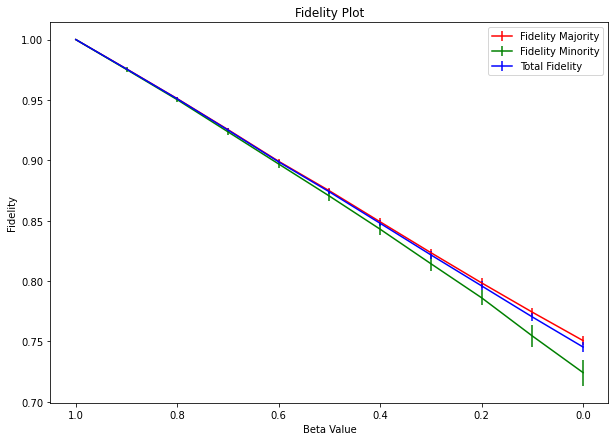

In [135]:
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, mean_fidel_maj2, yerr = y_err_fidel_maj2, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, mean_fidel_min2, yerr = y_err_fidel_min2, label = 'Fidelity Minority', color = "green")
plt.errorbar(bias_amts, mean_fidel2, yerr = y_err_fidel2, label = 'Total Fidelity', color = "blue")
plt.xlabel("Beta Value")
plt.ylabel("Fidelity")
plt.xlim(1.05, -0.05)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig(f'without_intervention_numiters{num_iters}_n{n}_eta{eta}.jpg')
plt.show()

# Exploration

## Representation

In [13]:
def representation(r, n, apply_fairness = True, verbose = False, num_iters = 10, inter = False, diff_base = False):
    
    total_fidel_maj = []
    total_fidel_min = []
    total_fidel = []
    
    total_disp_bias_train = []
    total_disp_bo_train = []
    total_disp_mitigated_train = []
    
    total_disp_bias_test = []
    total_disp_bo_test = []
    total_disp_mitigated_test = []
    
    for i in range(num_iters):
    
        # 1 to 0 in increments of 0.1
        bias_amts = np.divide(list(range(10,-1,-1)),10)
        bias_amts[-1] = 0.01

        test_maj = []
        test_min = []
        total = []
        
        disp_bias_train = []
        disp_bo_train = []
        disp_mitigated_train = []
        
        disp_bias_test = []
        disp_bo_test = []
        disp_mitigated_test = []
        
        count = 0
        
        if diff_base: 
            outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n, maj_means =[0.7,0.7,0.7])
        else: outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n)        
        
        threshold = 0.5
        exact_bo_labels = np.where(outcome_continuous < threshold, 0, 1)
        exact_bo_labels_train = np.array(exact_bo_labels[range(0,n)])
        exact_bo_labels_test = np.array(exact_bo_labels[range(n,len(df_synthetic))])
        
        # split into train and test
        df_train = df_synthetic.loc[range(0,n), :]
        
        df_train_transf, maj_list, min_list = transform(df_train, True, True)
        
        df_test = df_synthetic.loc[range(n, len(df_synthetic)),:]
        df_test_transf, maj_list, min_list = transform(df_test, True, False)
        
        df_test_maj = df_test_transf.loc[maj_list]
        df_test_min = df_test_transf.loc[min_list]

        # format training data
        X_true = df_train_transf.iloc[:, :-1].values
        y_true = df_train_transf.iloc[:, -1].values
        
        # format test data
        X_test = df_test_transf.iloc[:, :-1].values
        X_test_maj = df_test_maj.iloc[:, :-1].values
        X_test_min = df_test_min.iloc[:, :-1].values
        y_test = df_test_transf.iloc[:, -1].values
        y_test_maj = df_test_maj.iloc[:, -1].values
        y_test_min = df_test_min.iloc[:, -1].values
        
        sens_attr_test = df_test['cat']
        
        for beta in bias_amts:
            
            if i == 0: print("Beta: ", beta, '\n')

            df_train_copy = df_train.copy()

            df_majority = df_train_copy[df_train_copy['cat'] == 1]
            df_minority = df_train_copy[df_train_copy['cat'] == 0]

            if inter:
                # unfavored group with negative label
                df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

                # unfavored group with positive label (preferred)
                df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

                # data frame without positively labeled examples from minority class
                df_total = pd.concat([df_majority, df_minority_negative])

                df_undersampled = under(df_minority_positive, beta)

                # combine undersampled and original favored class to create dataset
                df_concat = pd.concat([df_total,df_undersampled]).sample(frac=1, random_state = 42) # permute data

            else:
                df_undersampled = under(df_minority, beta)

                # combine undersampled and original favored class to create dataset
                df_concat = pd.concat([df_majority,df_undersampled])
                df_concat.sample(frac=1, random_state = 42) # permute data

            # format data
            X_bias_true, y_bias_true, df_sens = transform(df_concat)
            
            # model trained on biased data
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_bias = classifier.fit(X_bias_true, y_bias_true)
            
            acc = accuracy_score(y_test,classifier_bias.predict(X_test))
            #print(f'Biased classifier:')
            #print(f'     Test accuracy = {acc}')
            
            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bias_train += [disparity.gamma(classify).max()]

            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bias_test += [disparity.gamma(classify).max()]
            
            # Learned bayes optimal classifier
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_b = classifier.fit(X_true, y_true)                
            #classifier_b = clone(classifier).fit(X_true, y_true)
            acc = accuracy_score(y_test,classifier_b.predict(X_test))
            #print(f'Learned BO classifier:')
            #print(f'     Test accuracy = {acc}')
            
            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bo_train += [disparity.gamma(classify).max()]

            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bo_test += [disparity.gamma(classify).max()]
            
            
            # Exact BO optimal classifier
            #print(f'Exact BO classifier:')
            acc = accuracy_score(y_test,exact_bo_labels_test)
            #print(f'     Test accuracy = {acc}')
            acc = accuracy_score(y_true,exact_bo_labels_train)
            #print(f'     Train accuracy = {acc}')

            if apply_fairness:
                constraint = EqualizedOdds()
                classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none', fit_intercept = False, max_iter = 200)   

                classifier_mitigated_bias = GridSearch(estimator=classifier,
                                                       constraints=constraint,
                                                       selection_rule='tradeoff_optimization',
                                                       constraint_weight=0.5,
                                                       grid_size=10,
                                                       grid_limit=2.0,
                                                       grid_offset=None,
                                                       grid=None,
                                                       sample_weight_name='sample_weight')
                                                       
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
                
                acc = accuracy_score(y_test,classifier_mitigated_bias.predict(X_test))
                #print(f'Mitigated bias classifier:')
                #print(f'     Test accuracy = {acc}')
                
                m = classifier_mitigated_bias
                def classify(X): return m.predict(X)
                error = ErrorRate()
                error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                disparity = EqualizedOdds()
                disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                #print(f'     Train error = {error.gamma(classify)[0]}')
                #print(f'     Train disparity = {disparity.gamma(classify).max()}')
                disp_mitigated_train += [disparity.gamma(classify).max()]
                
                m = classifier_mitigated_bias
                def classify(X): return m.predict(X)
                error = ErrorRate()
                error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                disparity = EqualizedOdds()
                disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                #print(f'     Test error = {error.gamma(classify)[0]}')
                #print(f'     Test disparity = {disparity.gamma(classify).max()}')
                disp_mitigated_test += [disparity.gamma(classify).max()]
                
                # Alternative fidelity of intervention model to no intervention model
                alt_fid_train = accuracy_score(classifier_mitigated_bias.predict(X_bias_true),classifier_bias.predict(X_bias_true))
                alt_fid_test = accuracy_score(classifier_mitigated_bias.predict(X_test),classifier_bias.predict(X_test))
                #print(f'Alternative fidelity of intervention model to no intervention model: train = {alt_fid_train}, test = {alt_fid_test}')
                

            else:
                classifier_mitigated_bias = clone(classifier_bias)
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true)
                
                # NOTE: disparities are the same as for classifier_bias

                
            # Fidelity in this step
            fid = accuracy_score(classifier_mitigated_bias.predict(X_test),classifier_b.predict(X_test))
            #print(f'Test set fidelity of learned BO classifier and mitigated_bias_classifier: {fid}')
            fid = accuracy_score(classifier_mitigated_bias.predict(X_test),exact_bo_labels_test)
            #print(f'Test set fidelity of exact BO classifier and mitigated biased classifier: {fid}')
            fid = accuracy_score(classifier_bias.predict(X_test),classifier_b.predict(X_test))
            #print(f'Test set fidelity of learned BO classifier and biased classifier: {fid}')
            
            # fidelity check
            test_maj += [accuracy_score(classifier_mitigated_bias.predict(X_test_maj), classifier_b.predict(X_test_maj))]
            test_min += [accuracy_score(classifier_mitigated_bias.predict(X_test_min), classifier_b.predict(X_test_min))]
            total += [accuracy_score(classifier_mitigated_bias.predict(X_test), classifier_b.predict(X_test))]
                
            if verbose:
                print("Finished Iteration: ", count)
                count +=1
        
        #print(f'Fidelity test maj: {test_maj}')
        #print(f'Fidelity test min: {test_maj}')
        
        total_fidel_maj.append(test_maj)
        total_fidel_min.append(test_min)
        total_fidel.append(total)
        
        total_disp_bias_train.append(disp_bias_train)
        total_disp_bo_train.append(disp_bo_train)
        total_disp_mitigated_train.append(disp_mitigated_train)

        total_disp_bias_test.append(disp_bias_test)
        total_disp_bo_test.append(disp_bo_test)
        total_disp_mitigated_test.append(disp_mitigated_test)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)
    
    mean_fidel_maj = np.mean(total_fidel_maj, axis = 0)
    mean_fidel_min = np.mean(total_fidel_min, axis = 0)
    mean_fidel = np.mean(total_fidel, axis = 0)
    
    mean_disp_bias_train = np.mean(total_disp_bias_train, axis = 0)
    mean_disp_bo_train = np.mean(total_disp_bo_train, axis = 0)
    mean_disp_mitigated_train = np.mean(total_disp_mitigated_train, axis = 0)
    
    mean_disp_bias_test = np.mean(total_disp_bias_test, axis = 0)
    mean_disp_bo_test = np.mean(total_disp_bo_test, axis = 0)
    mean_disp_mitigated_test = np.mean(total_disp_mitigated_test, axis = 0)
    
    y_err_fidel_maj = np.std(total_fidel_maj, axis = 0)
    y_err_fidel_min = np.std(total_fidel_min, axis = 0)
    y_err_fidel = np.std(total_fidel, axis = 0)
    
    df = pd.DataFrame({"Biased Train" : mean_disp_bias_train,
                       "BO Train" : mean_disp_bo_train,
                       "Mitigated Train" : mean_disp_mitigated_train,
                       "Biased Test" : mean_disp_bias_test,
                       "BO Test" : mean_disp_bo_test,
                       "Mitigated Test" : mean_disp_mitigated_test})
   
    return bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df

In [14]:
random.seed(42)
np.random.seed(42)

eta = 0.2
n = 30000
r = 0.2
num_iters = 10

bias_amts, mean_fidel_maj21, mean_fidel_min21, mean_fidel21, y_err_fidel_maj21, y_err_fidel_min21, y_err_fidel21, df = \
representation(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = False, inter = False)

df.to_csv('repr_no_inter.csv', index = True)

Diff:  0.008458333333333345
Beta:  1.0 

Total Deleted:  0 	 % Deleted:  0.0
Finished Iteration:  0
Beta:  0.9 

Total Deleted:  601 	 % Deleted:  0.10145172180958811
Finished Iteration:  1
Beta:  0.8 

Total Deleted:  1236 	 % Deleted:  0.2086428089128967
Finished Iteration:  2
Beta:  0.7 

Total Deleted:  1809 	 % Deleted:  0.30536799459824443
Finished Iteration:  3
Beta:  0.6 

Total Deleted:  2306 	 % Deleted:  0.38926401080351114
Finished Iteration:  4
Beta:  0.5 

Total Deleted:  2962 	 % Deleted:  0.5
Finished Iteration:  5
Beta:  0.4 

Total Deleted:  3579 	 % Deleted:  0.6041525995948683
Finished Iteration:  6
Beta:  0.3 

Total Deleted:  4085 	 % Deleted:  0.6895678595543552
Finished Iteration:  7
Beta:  0.2 

Total Deleted:  4729 	 % Deleted:  0.7982781904118839
Finished Iteration:  8
Beta:  0.1 

Total Deleted:  5331 	 % Deleted:  0.899898717083052
Finished Iteration:  9
Beta:  0.01 

Total Deleted:  5872 	 % Deleted:  0.9912221471978393
Finished Iteration:  10
Finished Tot

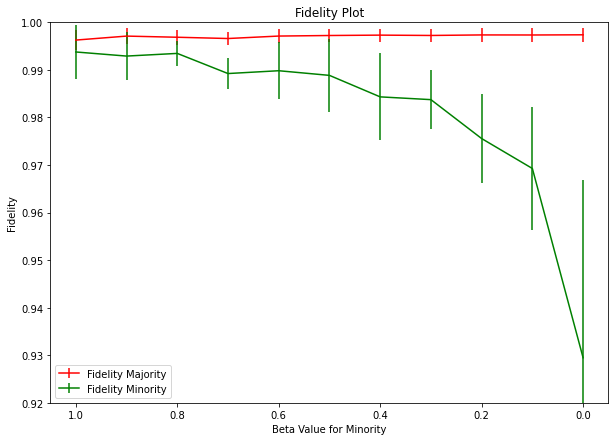

In [15]:
bias_amts = np.divide(list(range(10,-1,-1)),10)
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, mean_fidel_maj21, yerr = y_err_fidel_maj21, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, mean_fidel_min21, yerr = y_err_fidel_min21, label = 'Fidelity Minority', color = "green")
plt.xlabel("Beta Value for Minority")
plt.ylabel("Fidelity")
plt.xlim(1.05, -0.05)
plt.ylim(0.92, 1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('repr_no_inter.jpg')
plt.show()

In [16]:
random.seed(42)
np.random.seed(42)

eta = 0.2
n = 30000
r = 0.2
num_iters = 10

bias_amts, mean_fidel_maj22, mean_fidel_min22, mean_fidel22, y_err_fidel_maj22, y_err_fidel_min22, y_err_fidel22, df = \
representation(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = False, inter = True)

df.to_csv('repr_inter.csv', index = True)

Diff:  0.008458333333333345
Beta:  1.0 

Total Deleted:  0 	 % Deleted:  0.0
Finished Iteration:  0
Beta:  0.9 

Total Deleted:  296 	 % Deleted:  0.10088616223585549
Finished Iteration:  1
Beta:  0.8 

Total Deleted:  576 	 % Deleted:  0.19631901840490798
Finished Iteration:  2
Beta:  0.7 

Total Deleted:  878 	 % Deleted:  0.2992501704158146
Finished Iteration:  3
Beta:  0.6 

Total Deleted:  1187 	 % Deleted:  0.4045671438309475
Finished Iteration:  4
Beta:  0.5 

Total Deleted:  1481 	 % Deleted:  0.5047716428084527
Finished Iteration:  5
Beta:  0.4 

Total Deleted:  1786 	 % Deleted:  0.6087252897068848
Finished Iteration:  6
Beta:  0.3 

Total Deleted:  2118 	 % Deleted:  0.721881390593047
Finished Iteration:  7
Beta:  0.2 

Total Deleted:  2338 	 % Deleted:  0.7968643490115883
Finished Iteration:  8
Beta:  0.1 

Total Deleted:  2634 	 % Deleted:  0.8977505112474438
Finished Iteration:  9
Beta:  0.01 

Total Deleted:  2901 	 % Deleted:  0.9887525562372188
Finished Iteration:  10


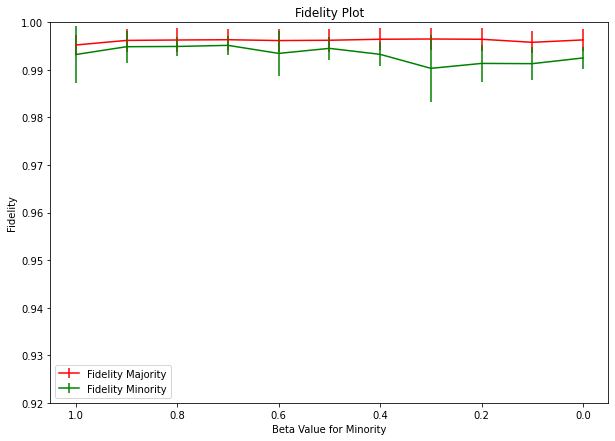

In [17]:
bias_amts = np.divide(list(range(10,-1,-1)),10)
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, mean_fidel_maj22, yerr = y_err_fidel_maj22, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, mean_fidel_min22, yerr = y_err_fidel_min22, label = 'Fidelity Minority', color = "green")
plt.xlabel("Beta Value for Minority")
plt.ylabel("Fidelity")
plt.xlim(1.05, -0.05)
plt.ylim(0.92, 1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('repr_inter.jpg')
plt.show()

In [18]:
random.seed(42)
np.random.seed(42)

eta = 0.2
n = 30000
r = 0.2
num_iters = 10

bias_amts, mean_fidel_maj23, mean_fidel_min23, mean_fidel23, y_err_fidel_maj23, y_err_fidel_min23, y_err_fidel23, df = \
representation(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = True, inter = True)

df.to_csv('repr_diff_base.csv', index = True)

Diff:  0.2084166666666667
Beta:  1.0 

Total Deleted:  0 	 % Deleted:  0.0
Finished Iteration:  0
Beta:  0.9 

Total Deleted:  296 	 % Deleted:  0.10088616223585549
Finished Iteration:  1
Beta:  0.8 

Total Deleted:  576 	 % Deleted:  0.19631901840490798
Finished Iteration:  2
Beta:  0.7 

Total Deleted:  878 	 % Deleted:  0.2992501704158146
Finished Iteration:  3
Beta:  0.6 

Total Deleted:  1187 	 % Deleted:  0.4045671438309475
Finished Iteration:  4
Beta:  0.5 

Total Deleted:  1481 	 % Deleted:  0.5047716428084527
Finished Iteration:  5
Beta:  0.4 

Total Deleted:  1786 	 % Deleted:  0.6087252897068848
Finished Iteration:  6
Beta:  0.3 

Total Deleted:  2118 	 % Deleted:  0.721881390593047
Finished Iteration:  7
Beta:  0.2 

Total Deleted:  2338 	 % Deleted:  0.7968643490115883
Finished Iteration:  8
Beta:  0.1 

Total Deleted:  2634 	 % Deleted:  0.8977505112474438
Finished Iteration:  9
Beta:  0.01 

Total Deleted:  2901 	 % Deleted:  0.9887525562372188
Finished Iteration:  10
Fi

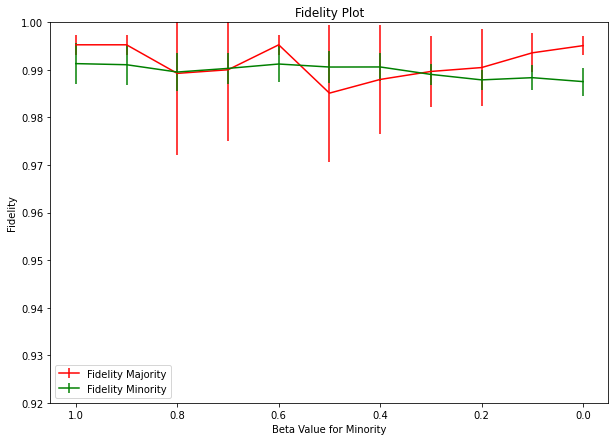

In [19]:
bias_amts = np.divide(list(range(10,-1,-1)),10)
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, mean_fidel_maj23, yerr = y_err_fidel_maj23, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, mean_fidel_min23, yerr = y_err_fidel_min23, label = 'Fidelity Minority', color = "green")
plt.xlabel("Beta Value for Minority")
plt.ylabel("Fidelity")
plt.xlim(1.05, -0.05)
plt.ylim(0.92, 1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('repr_diff_base.jpg')
plt.show()

## Label Noise

In [20]:
def flip(df_synthetic, eta):
    labels = df_synthetic['outcome'].values
    #print('Before:', df_synthetic['outcome'].value_counts())
    num_flipped = 0
    for i in range(len(labels)):
        if random.uniform(0,1) <= eta:
            labels[i] = 1 if labels[i] == 0 else 0
            num_flipped += 1
    df_synthetic['outcome'] = labels
    #print('After:', df_synthetic['outcome'].value_counts())
    print('Bias Num Flipped: ', num_flipped, "\tRate: ", num_flipped / len(df_synthetic))
    return df_synthetic

def get_noise(df, beta, inter = False):
    df_majority = df[df['cat'] == 1]
    df_minority = df[df['cat'] == 0]
    
    if inter:
        # unfavored group with negative label
        df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

        # unfavored group with positive label (preferred)
        df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

        # data frame without positively labeled examples from minority class
        df_total = pd.concat([df_majority, df_minority_negative])
        
        df_undersampled = flip(df_minority_positive, beta)

        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_total,df_undersampled])

        return df_concat.sample(frac=1, random_state = 42) # permute data
    
    else:
        df_undersampled = flip(df_minority, beta)

        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_majority,df_undersampled])

        return df_concat.sample(frac=1, random_state = 42) # permute data

In [21]:
def label_noise(r, n, apply_fairness = True, verbose = False, num_iters = 10, inter = False, diff_base = False):
    
    total_fidel_maj = []
    total_fidel_min = []
    total_fidel = []
    
    total_disp_bias_train = []
    total_disp_bo_train = []
    total_disp_mitigated_train = []
    
    total_disp_bias_test = []
    total_disp_bo_test = []
    total_disp_mitigated_test = []
    
    for i in range(num_iters):
    
        # 1 to 0 in increments of 0.1
        bias_amts = np.divide(list(range(1,11,1)),22)

        test_maj = []
        test_min = []
        total = []
        
        disp_bias_train = []
        disp_bo_train = []
        disp_mitigated_train = []
        
        disp_bias_test = []
        disp_bo_test = []
        disp_mitigated_test = []
        
        count = 0
        
        if diff_base: 
            outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n, maj_means =[0.7,0.7,0.7])
        else: outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n)        
        
        threshold = 0.5
        exact_bo_labels = np.where(outcome_continuous < threshold, 0, 1)
        exact_bo_labels_train = np.array(exact_bo_labels[range(0,n)])
        exact_bo_labels_test = np.array(exact_bo_labels[range(n,len(df_synthetic))])
        
        # split into train and test
        df_train = df_synthetic.loc[range(0,n), :]
        
        df_train_transf, maj_list, min_list = transform(df_train, True, True)
        
        df_test = df_synthetic.loc[range(n, len(df_synthetic)),:]
        df_test_transf, maj_list, min_list = transform(df_test, True, False)
        
        df_test_maj = df_test_transf.loc[maj_list]
        df_test_min = df_test_transf.loc[min_list]

        # format training data
        X_true = df_train_transf.iloc[:, :-1].values
        y_true = df_train_transf.iloc[:, -1].values
        
        # format test data
        X_test = df_test_transf.iloc[:, :-1].values
        X_test_maj = df_test_maj.iloc[:, :-1].values
        X_test_min = df_test_min.iloc[:, :-1].values
        y_test = df_test_transf.iloc[:, -1].values
        y_test_maj = df_test_maj.iloc[:, -1].values
        y_test_min = df_test_min.iloc[:, -1].values
        
        sens_attr_test = df_test['cat']
        
        for beta in bias_amts:
            
            if i == 0: print("Beta: ", beta, '\n')

            df_train_copy = df_train.copy()

            df_majority = df_train_copy[df_train_copy['cat'] == 1]
            df_minority = df_train_copy[df_train_copy['cat'] == 0]

            # unfavored group with negative label
            df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

            # unfavored group with positive label (preferred)
            df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

            # data frame without positively labeled examples from minority class
            df_total = pd.concat([df_majority, df_minority_negative])

            # under-sampling process
            df_undersampled = under(df_minority_positive, 1)

            # combine undersampled and original favored class to create dataset
            df_concat1 = pd.concat([df_total,df_undersampled])
            
            df_concat = get_noise(df_concat1, beta, inter) # group-dependent label noise

            # format data
            X_bias_true, y_bias_true, df_sens = transform(df_concat)
            
            # model trained on biased data
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_bias = classifier.fit(X_bias_true, y_bias_true)
            
            acc = accuracy_score(y_test,classifier_bias.predict(X_test))
            #print(f'Biased classifier:')
            #print(f'     Test accuracy = {acc}')
            
            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bias_train += [disparity.gamma(classify).max()]

            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bias_test += [disparity.gamma(classify).max()]
            
            # Learned bayes optimal classifier
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_b = classifier.fit(X_true, y_true)                
            #classifier_b = clone(classifier).fit(X_true, y_true)
            acc = accuracy_score(y_test,classifier_b.predict(X_test))
            #print(f'Learned BO classifier:')
            #print(f'     Test accuracy = {acc}')
            
            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bo_train += [disparity.gamma(classify).max()]

            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bo_test += [disparity.gamma(classify).max()]
            
            
            # Exact BO optimal classifier
            #print(f'Exact BO classifier:')
            acc = accuracy_score(y_test,exact_bo_labels_test)
            #print(f'     Test accuracy = {acc}')
            acc = accuracy_score(y_true,exact_bo_labels_train)
            #print(f'     Train accuracy = {acc}')

            if apply_fairness:
                constraint = EqualizedOdds()
                classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none', fit_intercept = False, max_iter = 200)   

                classifier_mitigated_bias = GridSearch(estimator=classifier,
                                                       constraints=constraint,
                                                       selection_rule='tradeoff_optimization',
                                                       constraint_weight=0.5,
                                                       grid_size=10,
                                                       grid_limit=2.0,
                                                       grid_offset=None,
                                                       grid=None,
                                                       sample_weight_name='sample_weight')
                                                       
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
                
                acc = accuracy_score(y_test,classifier_mitigated_bias.predict(X_test))
                #print(f'Mitigated bias classifier:')
                #print(f'     Test accuracy = {acc}')
                
                m = classifier_mitigated_bias
                def classify(X): return m.predict(X)
                error = ErrorRate()
                error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                disparity = EqualizedOdds()
                disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                #print(f'     Train error = {error.gamma(classify)[0]}')
                #print(f'     Train disparity = {disparity.gamma(classify).max()}')
                disp_mitigated_train += [disparity.gamma(classify).max()]
                
                m = classifier_mitigated_bias
                def classify(X): return m.predict(X)
                error = ErrorRate()
                error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                disparity = EqualizedOdds()
                disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                #print(f'     Test error = {error.gamma(classify)[0]}')
                #print(f'     Test disparity = {disparity.gamma(classify).max()}')
                disp_mitigated_test += [disparity.gamma(classify).max()]
                
                # Alternative fidelity of intervention model to no intervention model
                alt_fid_train = accuracy_score(classifier_mitigated_bias.predict(X_bias_true),classifier_bias.predict(X_bias_true))
                alt_fid_test = accuracy_score(classifier_mitigated_bias.predict(X_test),classifier_bias.predict(X_test))
                #print(f'Alternative fidelity of intervention model to no intervention model: train = {alt_fid_train}, test = {alt_fid_test}')
                

            else:
                classifier_mitigated_bias = clone(classifier_bias)
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true)
                
                # NOTE: disparities are the same as for classifier_bias

                
            # Fidelity in this step
            fid = accuracy_score(classifier_mitigated_bias.predict(X_test),classifier_b.predict(X_test))
            #print(f'Test set fidelity of learned BO classifier and mitigated_bias_classifier: {fid}')
            fid = accuracy_score(classifier_mitigated_bias.predict(X_test),exact_bo_labels_test)
            #print(f'Test set fidelity of exact BO classifier and mitigated biased classifier: {fid}')
            fid = accuracy_score(classifier_bias.predict(X_test),classifier_b.predict(X_test))
            #print(f'Test set fidelity of learned BO classifier and biased classifier: {fid}')
            
            # fidelity check
            test_maj += [accuracy_score(classifier_mitigated_bias.predict(X_test_maj), classifier_b.predict(X_test_maj))]
            test_min += [accuracy_score(classifier_mitigated_bias.predict(X_test_min), classifier_b.predict(X_test_min))]
            total += [accuracy_score(classifier_mitigated_bias.predict(X_test), classifier_b.predict(X_test))]
                
            if verbose:
                print("Finished Iteration: ", count)
                count +=1
        
        #print(f'Fidelity test maj: {test_maj}')
        #print(f'Fidelity test min: {test_maj}')
        
        total_fidel_maj.append(test_maj)
        total_fidel_min.append(test_min)
        total_fidel.append(total)
        
        total_disp_bias_train.append(disp_bias_train)
        total_disp_bo_train.append(disp_bo_train)
        total_disp_mitigated_train.append(disp_mitigated_train)

        total_disp_bias_test.append(disp_bias_test)
        total_disp_bo_test.append(disp_bo_test)
        total_disp_mitigated_test.append(disp_mitigated_test)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)
    
    mean_fidel_maj = np.mean(total_fidel_maj, axis = 0)
    mean_fidel_min = np.mean(total_fidel_min, axis = 0)
    mean_fidel = np.mean(total_fidel, axis = 0)
    
    mean_disp_bias_train = np.mean(total_disp_bias_train, axis = 0)
    mean_disp_bo_train = np.mean(total_disp_bo_train, axis = 0)
    mean_disp_mitigated_train = np.mean(total_disp_mitigated_train, axis = 0)
    
    mean_disp_bias_test = np.mean(total_disp_bias_test, axis = 0)
    mean_disp_bo_test = np.mean(total_disp_bo_test, axis = 0)
    mean_disp_mitigated_test = np.mean(total_disp_mitigated_test, axis = 0)
    
    y_err_fidel_maj = np.std(total_fidel_maj, axis = 0)
    y_err_fidel_min = np.std(total_fidel_min, axis = 0)
    y_err_fidel = np.std(total_fidel, axis = 0)
    
    df = pd.DataFrame({"Biased Train" : mean_disp_bias_train,
                       "BO Train" : mean_disp_bo_train,
                       "Mitigated Train" : mean_disp_mitigated_train,
                       "Biased Test" : mean_disp_bias_test,
                       "BO Test" : mean_disp_bo_test,
                       "Mitigated Test" : mean_disp_mitigated_test})
   
    return bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df

In [22]:
random.seed(42)
np.random.seed(42)

eta = 0.2
n = 30000
r = 0.2
num_iters = 10

bias_amts, mean_fidel_maj24, mean_fidel_min24, mean_fidel24, y_err_fidel_maj24, y_err_fidel_min24, y_err_fidel24, df = \
label_noise(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = False, inter = False)

df.to_csv('label_noise_no_inter.csv', index = True)

Diff:  0.008458333333333345
Beta:  0.045454545454545456 

Total Deleted:  0 	 % Deleted:  0.0
Bias Num Flipped:  273 	Rate:  0.046083727211343684
Finished Iteration:  0
Beta:  0.09090909090909091 

Total Deleted:  0 	 % Deleted:  0.0
Bias Num Flipped:  566 	Rate:  0.09554355165428764
Finished Iteration:  1
Beta:  0.13636363636363635 

Total Deleted:  0 	 % Deleted:  0.0
Bias Num Flipped:  800 	Rate:  0.1350438892640108
Finished Iteration:  2
Beta:  0.18181818181818182 

Total Deleted:  0 	 % Deleted:  0.0
Bias Num Flipped:  1073 	Rate:  0.1811276164753545
Finished Iteration:  3
Beta:  0.22727272727272727 

Total Deleted:  0 	 % Deleted:  0.0
Bias Num Flipped:  1386 	Rate:  0.2339635381498987
Finished Iteration:  4
Beta:  0.2727272727272727 

Total Deleted:  0 	 % Deleted:  0.0
Bias Num Flipped:  1634 	Rate:  0.27582714382174206
Finished Iteration:  5
Beta:  0.3181818181818182 

Total Deleted:  0 	 % Deleted:  0.0
Bias Num Flipped:  1875 	Rate:  0.3165091154625253
Finished Iteration:  6

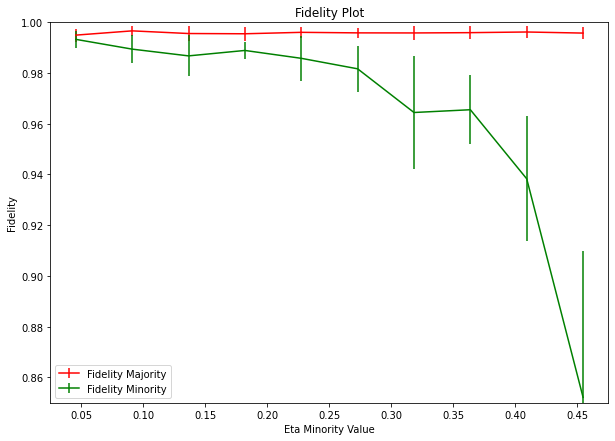

In [23]:
bias_amts = np.divide(list(range(1,11,1)),22)
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, mean_fidel_maj24, yerr = y_err_fidel_maj24, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, mean_fidel_min24, yerr = y_err_fidel_min24, label = 'Fidelity Minority', color = "green")
plt.xlabel("Eta Minority Value")
plt.ylabel("Fidelity")
plt.ylim(0.85,1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('label_noise_no_inter.jpg')
plt.show()

In [ ]:
random.seed(42)
np.random.seed(42)

eta = 0.2
n = 30000
r = 0.2
num_iters = 10
bias_amts, mean_fidel_maj25, mean_fidel_min25, mean_fidel25, y_err_fidel_maj25, y_err_fidel_min25, y_err_fidel25, df = \
label_noise(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = False, inter = True)

df.to_csv('label_noise_inter.csv', index = True)

Diff:  0.008458333333333345
Beta:  0.045454545454545456 

Total Deleted:  0 	 % Deleted:  0.0
Bias Num Flipped:  139 	Rate:  0.047375596455351054
Finished Iteration:  0
Beta:  0.09090909090909091 

Total Deleted:  0 	 % Deleted:  0.0
Bias Num Flipped:  274 	Rate:  0.09338786639400136
Finished Iteration:  1
Beta:  0.13636363636363635 

Total Deleted:  0 	 % Deleted:  0.0
Bias Num Flipped:  409 	Rate:  0.13940013633265166
Finished Iteration:  2
Beta:  0.18181818181818182 

Total Deleted:  0 	 % Deleted:  0.0
Bias Num Flipped:  488 	Rate:  0.1663258350374915
Finished Iteration:  3
Beta:  0.22727272727272727 

Total Deleted:  0 	 % Deleted:  0.0
Bias Num Flipped:  656 	Rate:  0.22358554873892297
Finished Iteration:  4
Beta:  0.2727272727272727 

Total Deleted:  0 	 % Deleted:  0.0
Bias Num Flipped:  809 	Rate:  0.27573278800272666
Finished Iteration:  5
Beta:  0.3181818181818182 

Total Deleted:  0 	 % Deleted:  0.0
Bias Num Flipped:  949 	Rate:  0.3234492160872529
Finished Iteration:  6
B

In [ ]:
bias_amts = np.divide(list(range(1,11,1)),22)
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, mean_fidel_maj25, yerr = y_err_fidel_maj25, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, mean_fidel_min25, yerr = y_err_fidel_min25, label = 'Fidelity Minority', color = "green")
plt.xlabel("Eta Minority Value")
plt.ylabel("Fidelity")
plt.ylim(0.85,1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('label_noise_inter.jpg')
plt.show()

In [ ]:
random.seed(42)
np.random.seed(42)

eta = 0.2
n = 30000
r = 0.2
num_iters = 10

bias_amts, mean_fidel_maj26, mean_fidel_min26, mean_fidel26, y_err_fidel_maj26, y_err_fidel_min26, y_err_fidel26, df = \
label_noise(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = True, inter = True)

df.to_csv('label_noise_diff_base.csv', index = True)

In [ ]:
bias_amts = np.divide(list(range(1,11,1)),22)
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, mean_fidel_maj26, yerr = y_err_fidel_maj26, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, mean_fidel_min26, yerr = y_err_fidel_min26, label = 'Fidelity Minority', color = "green")
plt.xlabel("Eta Minority Value")
plt.ylabel("Fidelity")
plt.ylim(0.85,1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('label_noise_diff_base.jpg')
plt.show()

## Feature Noise/Missingness

In [ ]:
def inject_noise_num(df, feature, eta, eps = 1):
    feats = df[feature].values
    #print('Before:', df_synthetic['outcome'].value_counts())
    num_flipped = 0
    for i in range(len(feats)):
        if random.uniform(0,1) <= eta:
            feats[i] = 0
            num_flipped += 1
    df[feature] = feats
    print('Num Flipped: ', num_flipped, "\tRate: ", num_flipped / len(df))
    return df

# measurement bias
def get_biased_data(df, eps, inter):
    df_majority = df[df['cat'] == 1]
    df_minority = df[df['cat'] == 0]
    
    if inter:
    
        # unfavored group with negative label
        df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

        # unfavored group with positive label (preferred)
        df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

        # data frame without positively labeled examples from minority class
        df_total = pd.concat([df_majority, df_minority_negative])

        # under-sampling process
        df_bias = inject_noise_num(df_minority_positive, 'num1', eps)

        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_total,df_bias])
    
    else:
        # under-sampling process
        df_bias = inject_noise_num(df_minority, 'num1', eps)
        # combine undersampled and original favored class to create dataset
        df_concat = pd.concat([df_majority,df_bias])
    
    return df_concat.sample(frac=1, random_state = 42) # permute data

In [ ]:
def measurement(r, n, apply_fairness = True, verbose = False, num_iters = 10, inter = False, diff_base = False):
    
    total_fidel_maj = []
    total_fidel_min = []
    total_fidel = []
    
    total_disp_bias_train = []
    total_disp_bo_train = []
    total_disp_mitigated_train = []
    
    total_disp_bias_test = []
    total_disp_bo_test = []
    total_disp_mitigated_test = []
    
    for i in range(num_iters):
    
        # 1 to 0 in increments of 0.1
        bias_amts = np.divide(list(range(0,11,1)),10)
        bias_amts[0] = 0.01 # doesn't work with 0

        test_maj = []
        test_min = []
        total = []
        
        disp_bias_train = []
        disp_bo_train = []
        disp_mitigated_train = []
        
        disp_bias_test = []
        disp_bo_test = []
        disp_mitigated_test = []
        
        count = 0
        
        if diff_base: 
            outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n, maj_means =[0.7,0.7,0.7])
        else: outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n)        
        
        threshold = 0.5
        exact_bo_labels = np.where(outcome_continuous < threshold, 0, 1)
        exact_bo_labels_train = np.array(exact_bo_labels[range(0,n)])
        exact_bo_labels_test = np.array(exact_bo_labels[range(n,len(df_synthetic))])
        
        # split into train and test
        df_train = df_synthetic.loc[range(0,n), :]
        
        df_train_transf, maj_list, min_list = transform(df_train, True, True)
        
        df_test = df_synthetic.loc[range(n, len(df_synthetic)),:]
        df_test_transf, maj_list, min_list = transform(df_test, True, False)
        
        df_test_maj = df_test_transf.loc[maj_list]
        df_test_min = df_test_transf.loc[min_list]

        # format training data
        X_true = df_train_transf.iloc[:, :-1].values
        y_true = df_train_transf.iloc[:, -1].values
        
        # format test data
        X_test = df_test_transf.iloc[:, :-1].values
        X_test_maj = df_test_maj.iloc[:, :-1].values
        X_test_min = df_test_min.iloc[:, :-1].values
        y_test = df_test_transf.iloc[:, -1].values
        y_test_maj = df_test_maj.iloc[:, -1].values
        y_test_min = df_test_min.iloc[:, -1].values
        
        sens_attr_test = df_test['cat']
        
        for beta in bias_amts:
            
            if i == 0: print("Beta: ", beta, '\n')

            df_train_copy = df_train.copy()

            df_majority = df_train_copy[df_train_copy['cat'] == 1]
            df_minority = df_train_copy[df_train_copy['cat'] == 0]

            # unfavored group with negative label
            df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

            # unfavored group with positive label (preferred)
            df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

            # data frame without positively labeled examples from minority class
            df_total = pd.concat([df_majority, df_minority_negative])

            # under-sampling process
            df_undersampled = under(df_minority_positive, 1)

            # combine undersampled and original favored class to create dataset
            df_concat1 = pd.concat([df_total,df_undersampled])
            
            df_concat = get_biased_data(df_concat1, beta, inter)

            # format data
            X_bias_true, y_bias_true, df_sens = transform(df_concat)
            
            # model trained on biased data
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_bias = classifier.fit(X_bias_true, y_bias_true)
            
            acc = accuracy_score(y_test,classifier_bias.predict(X_test))
            #print(f'Biased classifier:')
            #print(f'     Test accuracy = {acc}')
            
            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bias_train += [disparity.gamma(classify).max()]

            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bias_test += [disparity.gamma(classify).max()]
            
            # Learned bayes optimal classifier
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_b = classifier.fit(X_true, y_true)                
            #classifier_b = clone(classifier).fit(X_true, y_true)
            acc = accuracy_score(y_test,classifier_b.predict(X_test))
            #print(f'Learned BO classifier:')
            #print(f'     Test accuracy = {acc}')
            
            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bo_train += [disparity.gamma(classify).max()]

            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bo_test += [disparity.gamma(classify).max()]
            
            
            # Exact BO optimal classifier
            #print(f'Exact BO classifier:')
            acc = accuracy_score(y_test,exact_bo_labels_test)
            #print(f'     Test accuracy = {acc}')
            acc = accuracy_score(y_true,exact_bo_labels_train)
            #print(f'     Train accuracy = {acc}')

            if apply_fairness:
                constraint = EqualizedOdds()
                classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none', fit_intercept = False, max_iter = 200)   

                classifier_mitigated_bias = GridSearch(estimator=classifier,
                                                       constraints=constraint,
                                                       selection_rule='tradeoff_optimization',
                                                       constraint_weight=0.5,
                                                       grid_size=10,
                                                       grid_limit=2.0,
                                                       grid_offset=None,
                                                       grid=None,
                                                       sample_weight_name='sample_weight')
                                                       
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)
                
                acc = accuracy_score(y_test,classifier_mitigated_bias.predict(X_test))
                #print(f'Mitigated bias classifier:')
                #print(f'     Test accuracy = {acc}')
                
                m = classifier_mitigated_bias
                def classify(X): return m.predict(X)
                error = ErrorRate()
                error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                disparity = EqualizedOdds()
                disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
                #print(f'     Train error = {error.gamma(classify)[0]}')
                #print(f'     Train disparity = {disparity.gamma(classify).max()}')
                disp_mitigated_train += [disparity.gamma(classify).max()]
                
                m = classifier_mitigated_bias
                def classify(X): return m.predict(X)
                error = ErrorRate()
                error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                disparity = EqualizedOdds()
                disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
                #print(f'     Test error = {error.gamma(classify)[0]}')
                #print(f'     Test disparity = {disparity.gamma(classify).max()}')
                disp_mitigated_test += [disparity.gamma(classify).max()]
                
                # Alternative fidelity of intervention model to no intervention model
                alt_fid_train = accuracy_score(classifier_mitigated_bias.predict(X_bias_true),classifier_bias.predict(X_bias_true))
                alt_fid_test = accuracy_score(classifier_mitigated_bias.predict(X_test),classifier_bias.predict(X_test))
                #print(f'Alternative fidelity of intervention model to no intervention model: train = {alt_fid_train}, test = {alt_fid_test}')
                

            else:
                classifier_mitigated_bias = clone(classifier_bias)
                classifier_mitigated_bias.fit(X_bias_true, y_bias_true)
                
                # NOTE: disparities are the same as for classifier_bias

                
            # Fidelity in this step
            fid = accuracy_score(classifier_mitigated_bias.predict(X_test),classifier_b.predict(X_test))
            #print(f'Test set fidelity of learned BO classifier and mitigated_bias_classifier: {fid}')
            fid = accuracy_score(classifier_mitigated_bias.predict(X_test),exact_bo_labels_test)
            #print(f'Test set fidelity of exact BO classifier and mitigated biased classifier: {fid}')
            fid = accuracy_score(classifier_bias.predict(X_test),classifier_b.predict(X_test))
            #print(f'Test set fidelity of learned BO classifier and biased classifier: {fid}')
            
            # fidelity check
            test_maj += [accuracy_score(classifier_mitigated_bias.predict(X_test_maj), classifier_b.predict(X_test_maj))]
            test_min += [accuracy_score(classifier_mitigated_bias.predict(X_test_min), classifier_b.predict(X_test_min))]
            total += [accuracy_score(classifier_mitigated_bias.predict(X_test), classifier_b.predict(X_test))]
                
            if verbose:
                print("Finished Iteration: ", count)
                count +=1
        
        #print(f'Fidelity test maj: {test_maj}')
        #print(f'Fidelity test min: {test_maj}')
        
        total_fidel_maj.append(test_maj)
        total_fidel_min.append(test_min)
        total_fidel.append(total)
        
        total_disp_bias_train.append(disp_bias_train)
        total_disp_bo_train.append(disp_bo_train)
        total_disp_mitigated_train.append(disp_mitigated_train)

        total_disp_bias_test.append(disp_bias_test)
        total_disp_bo_test.append(disp_bo_test)
        total_disp_mitigated_test.append(disp_mitigated_test)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)
    
    mean_fidel_maj = np.mean(total_fidel_maj, axis = 0)
    mean_fidel_min = np.mean(total_fidel_min, axis = 0)
    mean_fidel = np.mean(total_fidel, axis = 0)
    
    mean_disp_bias_train = np.mean(total_disp_bias_train, axis = 0)
    mean_disp_bo_train = np.mean(total_disp_bo_train, axis = 0)
    mean_disp_mitigated_train = np.mean(total_disp_mitigated_train, axis = 0)
    
    mean_disp_bias_test = np.mean(total_disp_bias_test, axis = 0)
    mean_disp_bo_test = np.mean(total_disp_bo_test, axis = 0)
    mean_disp_mitigated_test = np.mean(total_disp_mitigated_test, axis = 0)
    
    y_err_fidel_maj = np.std(total_fidel_maj, axis = 0)
    y_err_fidel_min = np.std(total_fidel_min, axis = 0)
    y_err_fidel = np.std(total_fidel, axis = 0)
    
    df = pd.DataFrame({"Biased Train" : mean_disp_bias_train,
                       "BO Train" : mean_disp_bo_train,
                       "Mitigated Train" : mean_disp_mitigated_train,
                       "Biased Test" : mean_disp_bias_test,
                       "BO Test" : mean_disp_bo_test,
                       "Mitigated Test" : mean_disp_mitigated_test})
   
    return bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
random.seed(42)
np.random.seed(42)

eta = 0.2
n = 30000
r = 0.2
num_iters = 10

bias_amts, mean_fidel_maj27, mean_fidel_min27, mean_fidel27, y_err_fidel_maj27, y_err_fidel_min27, y_err_fidel27, df = \
measurement(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = False, inter = False)

df.to_csv('featmissing_no_inter.csv', index = True)

In [ ]:
bias_amts = np.divide(list(range(0,11,1)),10)
bias_amts[0] = 0.01 # doesn't work with 0

plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, mean_fidel_maj27, yerr = y_err_fidel_maj27, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, mean_fidel_min27, yerr = y_err_fidel_min27, label = 'Fidelity Minority', color = "green")
plt.xlabel("Eta Minority Value")
plt.ylabel("Fidelity")
plt.ylim(0.9, 1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('featmissing_no_inter.jpg')
plt.show()

In [ ]:
random.seed(42)
np.random.seed(42)

eta = 0.2
n = 30000
r = 0.2
num_iters = 10

bias_amts, mean_fidel_maj28, mean_fidel_min28, mean_fidel28, y_err_fidel_maj28, y_err_fidel_min28, y_err_fidel28, df = \
measurement(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = False, inter = True)

df.to_csv('featmissing_inter.csv', index = True)

In [ ]:
bias_amts = np.divide(list(range(0,11,1)),10)
bias_amts[0] = 0.01 # doesn't work with 0

plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, mean_fidel_maj28, yerr = y_err_fidel_maj28, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, mean_fidel_min28, yerr = y_err_fidel_min28, label = 'Fidelity Minority', color = "green")
plt.xlabel("Eta Minority Value")
plt.ylabel("Fidelity")
plt.ylim(0.9, 1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('featmissing_inter.jpg')
plt.show()

In [ ]:
random.seed(42)
np.random.seed(42)

eta = 0.2
n = 30000
r = 0.2
num_iters = 10

bias_amts, mean_fidel_maj29, mean_fidel_min29, mean_fidel29, y_err_fidel_maj29, y_err_fidel_min29, y_err_fidel29, df = \
measurement(r = r, n = n, apply_fairness=True,verbose=True, num_iters=num_iters, diff_base = True, inter = True)

df.to_csv('featmissing_diff_base.csv', index = True)

In [ ]:
bias_amts = np.divide(list(range(0,11,1)),10)
bias_amts[0] = 0.01 # doesn't work with 0

plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, mean_fidel_maj29, yerr = y_err_fidel_maj29, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, mean_fidel_min29, yerr = y_err_fidel_min29, label = 'Fidelity Minority', color = "green")
plt.xlabel("Eta Minority Value")
plt.ylabel("Fidelity")
plt.ylim(0.9, 1)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('featmissing_diff_base.jpg')
plt.show()

In [ ]:
def diff_base_rates(classifier, r, n, verbose = False, num_iters = 10):
    
    beta = 1
    bias_amts = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, .1, .2, .3, .4, .5]
    
    total_fidel_maj = []
    total_fidel_min = []
    total_fidel = []
    
    total_disp_bias_train = []
    total_disp_bo_train = []
    total_disp_mitigated_train = []
    
    total_disp_bias_test = []
    total_disp_bo_test = []
    total_disp_mitigated_test = []
    
    vals = [-4, -1.7, -1.1, -0.7, -0.3, 0, 0.35, 0.7, 1.15, 1.75, 4]
    
    for i in range(num_iters):

        test_maj = []
        test_min = []
        total = []
        
        disp_bias_train = []
        disp_bo_train = []
        disp_mitigated_train = []
        
        disp_bias_test = []
        disp_bo_test = []
        disp_mitigated_test = []
        
        count = 0
        
        for diff in vals:
            
            arr = np.ones(3)*diff
            outcome_continuous, df_synthetic = true_label_generation(r=r, eta=eta, n=2*n, maj_means = arr)

            threshold = 0.5
            exact_bo_labels = np.where(outcome_continuous < threshold, 0, 1)
            exact_bo_labels_train = np.array(exact_bo_labels[range(0,n)])
            exact_bo_labels_test = np.array(exact_bo_labels[range(n,len(df_synthetic))])

            # split into train and test
            df_train = df_synthetic.loc[range(0,n), :]

            df_train_transf, maj_list, min_list = transform(df_train, True, True)

            df_test = df_synthetic.loc[range(n, len(df_synthetic)),:]
            df_test_transf, maj_list, min_list = transform(df_test, True, False)

            df_test_maj = df_test_transf.loc[maj_list]
            df_test_min = df_test_transf.loc[min_list]

            # format training data
            X_true = df_train_transf.iloc[:, :-1].values
            y_true = df_train_transf.iloc[:, -1].values

            # format test data
            X_test = df_test_transf.iloc[:, :-1].values
            X_test_maj = df_test_maj.iloc[:, :-1].values
            X_test_min = df_test_min.iloc[:, :-1].values
            y_test = df_test_transf.iloc[:, -1].values
            y_test_maj = df_test_maj.iloc[:, -1].values
            y_test_min = df_test_min.iloc[:, -1].values

            sens_attr_test = df_test['cat']

            df_train_copy = df_train.copy()

            df_majority = df_train_copy[df_train_copy['cat'] == 1]
            df_minority = df_train_copy[df_train_copy['cat'] == 0]

            # unfavored group with negative label
            df_minority_negative = df_minority[df_minority['outcome'] == 0.0]

            # unfavored group with positive label (preferred)
            df_minority_positive = df_minority[df_minority['outcome'] == 1.0]

            # data frame without positively labeled examples from minority class
            df_total = pd.concat([df_majority, df_minority_negative])

            # under-sampling process
            df_undersampled = under(df_minority_positive, beta)

            # combine undersampled and original favored class to create dataset
            df_concat = pd.concat([df_total,df_undersampled]).sample(frac=1, random_state = 42)

            # format data
            X_bias_true, y_bias_true, df_sens = transform(df_concat)

            # model trained on biased data
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_bias = classifier.fit(X_bias_true, y_bias_true)

            acc = accuracy_score(y_test,classifier_bias.predict(X_test))
            #print(f'Biased classifier:')
            #print(f'     Test accuracy = {acc}')

            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bias_train += [disparity.gamma(classify).max()]

            m = classifier_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bias_test += [disparity.gamma(classify).max()]

            # Learned bayes optimal classifier
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none')
            classifier_b = classifier.fit(X_true, y_true)                
            #classifier_b = clone(classifier).fit(X_true, y_true)
            acc = accuracy_score(y_test,classifier_b.predict(X_test))
            #print(f'Learned BO classifier:')
            #print(f'     Test accuracy = {acc}')

            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_bo_train += [disparity.gamma(classify).max()]

            m = classifier_b
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_bo_test += [disparity.gamma(classify).max()]


            # Exact BO optimal classifier
            #print(f'Exact BO classifier:')
            acc = accuracy_score(y_test,exact_bo_labels_test)
            #print(f'     Test accuracy = {acc}')
            acc = accuracy_score(y_true,exact_bo_labels_train)
            #print(f'     Train accuracy = {acc}')

            constraint = EqualizedOdds()
            classifier = LogisticRegression(solver = 'lbfgs', random_state = 42, penalty = 'none', fit_intercept = False, max_iter = 200)   

            classifier_mitigated_bias = GridSearch(estimator=classifier,
                                                   constraints=constraint,
                                                   selection_rule='tradeoff_optimization',
                                                   constraint_weight=0.5,
                                                   grid_size=10,
                                                   grid_limit=2.0,
                                                   grid_offset=None,
                                                   grid=None,
                                                   sample_weight_name='sample_weight')

            classifier_mitigated_bias.fit(X_bias_true, y_bias_true, sensitive_features = df_sens)

            acc = accuracy_score(y_test,classifier_mitigated_bias.predict(X_test))
            #print(f'Mitigated bias classifier:')
            #print(f'     Test accuracy = {acc}')

            m = classifier_mitigated_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            disparity = EqualizedOdds()
            disparity.load_data(X_bias_true, pd.Series(y_bias_true), sensitive_features=df_sens)
            #print(f'     Train error = {error.gamma(classify)[0]}')
            #print(f'     Train disparity = {disparity.gamma(classify).max()}')
            disp_mitigated_train += [disparity.gamma(classify).max()]

            m = classifier_mitigated_bias
            def classify(X): return m.predict(X)
            error = ErrorRate()
            error.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            disparity = EqualizedOdds()
            disparity.load_data(X_test, pd.Series(y_test), sensitive_features=sens_attr_test)
            #print(f'     Test error = {error.gamma(classify)[0]}')
            #print(f'     Test disparity = {disparity.gamma(classify).max()}')
            disp_mitigated_test += [disparity.gamma(classify).max()]

            # Fidelity in this step
            fid = accuracy_score(classifier_mitigated_bias.predict(X_test),classifier_b.predict(X_test))
            #print(f'Test set fidelity of learned BO classifier and mitigated_bias_classifier: {fid}')
            fid = accuracy_score(classifier_mitigated_bias.predict(X_test),exact_bo_labels_test)
            #print(f'Test set fidelity of exact BO classifier and mitigated biased classifier: {fid}')
            fid = accuracy_score(classifier_bias.predict(X_test),classifier_b.predict(X_test))
            #print(f'Test set fidelity of learned BO classifier and biased classifier: {fid}')

            # fidelity check
            test_maj += [accuracy_score(classifier_mitigated_bias.predict(X_test_maj), classifier_b.predict(X_test_maj))]
            test_min += [accuracy_score(classifier_mitigated_bias.predict(X_test_min), classifier_b.predict(X_test_min))]
            total += [accuracy_score(classifier_mitigated_bias.predict(X_test), classifier_b.predict(X_test))]

            if verbose:
                print("Finished Iteration: ", count)
                count +=1
        
        #print(f'Fidelity test maj: {test_maj}')
        #print(f'Fidelity test min: {test_maj}')
        
        total_fidel_maj.append(test_maj)
        total_fidel_min.append(test_min)
        total_fidel.append(total)
        
        total_disp_bias_train.append(disp_bias_train)
        total_disp_bo_train.append(disp_bo_train)
        total_disp_mitigated_train.append(disp_mitigated_train)

        total_disp_bias_test.append(disp_bias_test)
        total_disp_bo_test.append(disp_bo_test)
        total_disp_mitigated_test.append(disp_mitigated_test)
        
        if verbose:
                print("Finished Total Iteration: ", i+1)
    
    mean_fidel_maj = np.mean(total_fidel_maj, axis = 0)
    mean_fidel_min = np.mean(total_fidel_min, axis = 0)
    mean_fidel = np.mean(total_fidel, axis = 0)
    
    mean_disp_bias_train = np.mean(total_disp_bias_train, axis = 0)
    mean_disp_bo_train = np.mean(total_disp_bo_train, axis = 0)
    mean_disp_mitigated_train = np.mean(total_disp_mitigated_train, axis = 0)
    
    mean_disp_bias_test = np.mean(total_disp_bias_test, axis = 0)
    mean_disp_bo_test = np.mean(total_disp_bo_test, axis = 0)
    mean_disp_mitigated_test = np.mean(total_disp_mitigated_test, axis = 0)
    
    y_err_fidel_maj = np.std(total_fidel_maj, axis = 0)
    y_err_fidel_min = np.std(total_fidel_min, axis = 0)
    y_err_fidel = np.std(total_fidel, axis = 0)
    
    df = pd.DataFrame({"Biased Train" : mean_disp_bias_train,
                       "BO Train" : mean_disp_bo_train,
                       "Mitigated Train" : mean_disp_mitigated_train,
                       "Biased Test" : mean_disp_bias_test,
                       "BO Test" : mean_disp_bo_test,
                       "Mitigated Test" : mean_disp_mitigated_test})
   
    return bias_amts, mean_fidel_maj, mean_fidel_min, mean_fidel, y_err_fidel_maj, y_err_fidel_min, y_err_fidel, df

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

random.seed(42)
np.random.seed(42)

eta = 0.2
n = 30000
r = 0.2
num_iters = 10

bias_amts, mean_fidel_maj30, mean_fidel_min30, mean_fidel30, y_err_fidel_maj30, y_err_fidel_min30, y_err_fidel30, df = \
diff_base_rates(classifier,r = r, n = n, verbose=True, num_iters=num_iters)

df.to_csv(f'diff_base_rates{num_iters}_n{n}_eta{eta}.csv', index = True)

In [ ]:
bias_amts = [-0.5, -0.4, -0.3, -0.2, -0.1, 0, .1, .2, .3, .4, .5]
plt.figure(figsize=(10,7))
plt.errorbar(bias_amts, mean_fidel_maj30, yerr = y_err_fidel_maj30, label = 'Fidelity Majority', color = "red")
plt.errorbar(bias_amts, mean_fidel_min30, yerr = y_err_fidel_min30, label = 'Fidelity Minority', color = "green")
plt.xlabel("Difference in Proportion of Positive Labels (Majority - Minority)")
plt.ylabel("Fidelity")
#plt.xlim(-0.4, 0.5)
#plt.ylim(0.9, 1)
#plt.xlim(1.05, -0.05)
plt.legend()
plt.title("Fidelity Plot")
plt.savefig('diff_base_rates.jpg')
plt.show()